In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

plt.style.use('ggplot')

import re
import nltk
from nltk.stem import WordNetLemmatizer

In [40]:
# df = pd.read_csv("data/imdb.csv", sep=',')
df = pd.read_csv("data/rt/rt.csv", sep=',')

In [41]:
df.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,positive
1,"the gorgeously elaborate continuation of "" the...",positive
2,effective but too-tepid biopic,positive
3,if you sometimes like to go to the movies to h...,positive
4,"emerges as something rare , an issue movie tha...",positive


In [42]:
# ----- Get labels -----
y = np.int32(df.sentiment.astype('category').cat.codes.to_numpy())
# ----- Get number of classes -----
num_classes = np.unique(y).shape[0]

In [43]:
print(y)

[1 1 1 ... 0 0 0]


In [44]:
stemmer = WordNetLemmatizer()


def custom_standardization(text):
    text = re.sub('<br />', ' ', str(text))

    text = re.sub(r'\W', ' ', str(text))

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # converting to Lowercase
    text = text.lower()

    # lemmatization
    text = text.split()

    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)

    return text
    pass

In [45]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\new\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\new\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [46]:
df['Cleaned_Text'] = df.review.apply(custom_standardization)

In [47]:
df['Cleaned_Text'].head()

0    the rock is destined to be the 21st century ne...
1    the gorgeously elaborate continuation of the l...
2                       effective but too tepid biopic
3    if you sometimes like to go to the movie to ha...
4    emerges a something rare an issue movie that s...
Name: Cleaned_Text, dtype: object

In [48]:
# ----- Prepare text for embedding -----
max_features = 10000

In [49]:
# ----- Get top 10000 most occuring words in list-----
results = Counter()
df['Cleaned_Text'].str.split().apply(results.update)
vocabulary = [key[0] for key in results.most_common(max_features)]

# ----- Create tokenizer based on your top 10000 words -----
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(vocabulary)

0        None
1        None
2        None
3        None
4        None
         ... 
10656    None
10657    None
10658    None
10659    None
10660    None
Name: Cleaned_Text, Length: 10661, dtype: object

In [50]:
# ----- Convert words to ints and pad -----
X = tokenizer.texts_to_sequences(df['Cleaned_Text'].values)
X = pad_sequences(X)

# ----- Split into Train, Test, Validation sets -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [51]:
output_dim = 16
max_input_lenght = X.shape[1]

In [52]:
 # path_to_glove_file = "/checkpoints/yahoo/gau_e_1/fine_tune.txt"
path_to_glove_file = "./checkpoints/rt_gau_0.1_wiki-news-300d-1M.vec/fine_tune.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 10005 word vectors.


In [53]:
word_index = dict(zip(vocabulary, range(len(vocabulary))))
num_tokens = len(vocabulary) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8040 words (1960 misses)


In [25]:
import random
from scipy.stats import bernoulli
from scipy.stats import norm
from scipy.stats import laplace


def rlaplace(mean, scale):
    sgn = 2 * bernoulli.rvs(0.5) - 1
    return (mean - scale * sgn * np.log(random.uniform(0, 1)))


def rtrunclaplace(n, mean, scale, lower, upper):
    out = []
    while len(out) < n:
        r = rlaplace(mean, scale)
        if (r > lower and r < upper):
            out.append(r)
    return np.array(out)

# 0-50
e = 1
# ε≤4∆1∆∞
C = 0.005
d1 = 2 * np.sqrt(300) * C
dinf = 2 * C
# first set e = 1
a = e/d1
scale  = 1/a
A = -(d1/e) * np.log(1-(2 * e/np.sqrt(300)))

In [26]:
noise =  np.empty((0, embedding_dim))
for i in range(0,num_tokens):
    noise = np.concatenate((noise,rtrunclaplace(300,mean=0, scale=scale, lower=-A, upper=A).reshape(-1, 300)),axis=0)

In [21]:
noise =  np.empty((0, embedding_dim))
for i in range(0,num_tokens):
    noise = np.concatenate((noise, laplace.rvs(loc=0, scale=scale,size=300).reshape(-1, 300)),axis=0)

In [22]:
noise =  np.empty((0, embedding_dim))
for i in range(0,num_tokens):
    noise = np.concatenate((noise, norm.rvs(loc = 0, scale = np.sqrt(2*(np.log(1.25)+d*np.log(2)))*C/e, size=300).reshape(-1, 300)),axis=0)

In [27]:
embedding_matrix =  np.random.uniform(-C, C, size=[num_tokens, embedding_dim]) + noise
embedding_matrix

array([[ 0.00797653,  0.00643291,  0.0023789 , ...,  0.00392921,
         0.00236657, -0.01824509],
       [-0.01254968,  0.01812921, -0.01401869, ...,  0.00121689,
         0.01847122,  0.02057171],
       [-0.00265675, -0.01037658,  0.02235966, ..., -0.00042689,
        -0.0057127 , -0.01202456],
       ...,
       [ 0.00699218,  0.00916533,  0.01723085, ...,  0.0004955 ,
         0.00927218,  0.00471995],
       [ 0.00035215, -0.02089669, -0.01066997, ...,  0.01599979,
        -0.00947658, -0.01172979],
       [ 0.00584103,  0.00758239, -0.00902629, ...,  0.01178456,
         0.01531006,  0.00757941]])

In [28]:
np.random.seed(42)
embedding_matrix = np.random.uniform(-C, C, size=[num_tokens, embedding_dim])

In [29]:
embedding_matrix

array([[-0.0012546 ,  0.00450714,  0.00231994, ..., -0.00284179,
         0.0012289 , -0.00414653],
       [-0.00448318,  0.00031355,  0.00040635, ..., -0.0032768 ,
        -0.00307711, -0.00459131],
       [-0.00331065, -0.0022141 , -0.0032299 , ...,  0.00396336,
        -0.00486998, -0.00414491],
       ...,
       [-0.00030222,  0.00460947, -0.00105273, ...,  0.00201195,
        -0.00098657, -0.00496274],
       [ 0.00244655, -0.00249474,  0.00185201, ...,  0.00284964,
        -0.00361792, -0.00386512],
       [-0.00191571,  0.00408757, -0.00376592, ...,  0.00335605,
        -0.00262383, -0.00288215]])

In [54]:
# ----- Define model -----
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    input_length=max_input_lenght,
    #trainable = False,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# ----- Compile model -----
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           3000600   
                                                                 
 dropout_1 (Dropout)         (None, 50, 300)           0         
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                4816      
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,005,450
Trainable params: 3,005,450
Non-trainable params: 0
____________________________________________

In [56]:
# ----- Train model -----
history_1 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
214/214 [==============================] - 8s 34ms/step - loss: 0.6933 - accuracy: 0.5062 - val_loss: 0.6922 - val_accuracy: 0.5434
Epoch 2/20
214/214 [==============================] - 7s 33ms/step - loss: 0.6909 - accuracy: 0.5547 - val_loss: 0.6907 - val_accuracy: 0.5897
Epoch 3/20
214/214 [==============================] - 7s 33ms/step - loss: 0.6883 - accuracy: 0.5981 - val_loss: 0.6891 - val_accuracy: 0.5487
Epoch 4/20
214/214 [==============================] - 7s 33ms/step - loss: 0.6841 - accuracy: 0.5907 - val_loss: 0.6843 - val_accuracy: 0.6290
Epoch 5/20
214/214 [==============================] - 7s 34ms/step - loss: 0.6777 - accuracy: 0.6394 - val_loss: 0.6815 - val_accuracy: 0.5557
Epoch 6/20
214/214 [==============================] - 7s 33ms/step - loss: 0.6698 - accuracy: 0.6780 - val_loss: 0.6740 - val_accuracy: 0.6829
Epoch 7/20
214/214 [==============================] - 7s 33ms/step - loss: 0.6598 - accuracy: 0.7284 - val_loss: 0.6664 - val_accuracy: 0.6887

In [33]:
# ----- Train model -----
history_2 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
214/214 [==============================] - 7s 33ms/step - loss: 0.1460 - accuracy: 0.9622 - val_loss: 0.5179 - val_accuracy: 0.7608
Epoch 2/20
214/214 [==============================] - 7s 34ms/step - loss: 0.1355 - accuracy: 0.9645 - val_loss: 0.5277 - val_accuracy: 0.7614
Epoch 3/20
214/214 [==============================] - 7s 34ms/step - loss: 0.1259 - accuracy: 0.9682 - val_loss: 0.5374 - val_accuracy: 0.7614
Epoch 4/20
214/214 [==============================] - 7s 34ms/step - loss: 0.1171 - accuracy: 0.9702 - val_loss: 0.5487 - val_accuracy: 0.7591
Epoch 5/20
214/214 [==============================] - 7s 34ms/step - loss: 0.1095 - accuracy: 0.9749 - val_loss: 0.5612 - val_accuracy: 0.7632
Epoch 6/20
214/214 [==============================] - 8s 35ms/step - loss: 0.1017 - accuracy: 0.9763 - val_loss: 0.5726 - val_accuracy: 0.7644
Epoch 7/20
214/214 [==============================] - 8s 35ms/step - loss: 0.0941 - accuracy: 0.9796 - val_loss: 0.5871 - val_accuracy: 0.7644

In [34]:
# ----- Train model -----
history_3 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0363 - accuracy: 0.9941 - val_loss: 0.8180 - val_accuracy: 0.7573
Epoch 2/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0334 - accuracy: 0.9949 - val_loss: 0.8372 - val_accuracy: 0.7579
Epoch 3/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0316 - accuracy: 0.9957 - val_loss: 0.8562 - val_accuracy: 0.7556
Epoch 4/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0294 - accuracy: 0.9955 - val_loss: 0.8797 - val_accuracy: 0.7538
Epoch 5/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0271 - accuracy: 0.9968 - val_loss: 0.8949 - val_accuracy: 0.7509
Epoch 6/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0253 - accuracy: 0.9962 - val_loss: 0.9153 - val_accuracy: 0.7503
Epoch 7/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0242 - accuracy: 0.9965 - val_loss: 0.9469 - val_accuracy: 0.7433

In [35]:
# ----- Train model -----
history_4 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0086 - accuracy: 0.9991 - val_loss: 1.2356 - val_accuracy: 0.7409
Epoch 2/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0081 - accuracy: 0.9996 - val_loss: 1.2574 - val_accuracy: 0.7397
Epoch 3/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0072 - accuracy: 0.9993 - val_loss: 1.2775 - val_accuracy: 0.7403
Epoch 4/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0069 - accuracy: 0.9996 - val_loss: 1.2991 - val_accuracy: 0.7415
Epoch 5/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 1.3328 - val_accuracy: 0.7374
Epoch 6/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0061 - accuracy: 0.9997 - val_loss: 1.3436 - val_accuracy: 0.7403
Epoch 7/20
214/214 [==============================] - 7s 34ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 1.3682 - val_accuracy: 0.7433

## **Evaluate the model**

In [57]:
# ----- Evaluate model -----
probabilities = model.predict(X_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

67/67 [==============================] - 0s 2ms/step
 
Results
Accuracy: 0.7478
 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1071
           1       0.75      0.75      0.75      1062

    accuracy                           0.75      2133
   macro avg       0.75      0.75      0.75      2133
weighted avg       0.75      0.75      0.75      2133



In [37]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

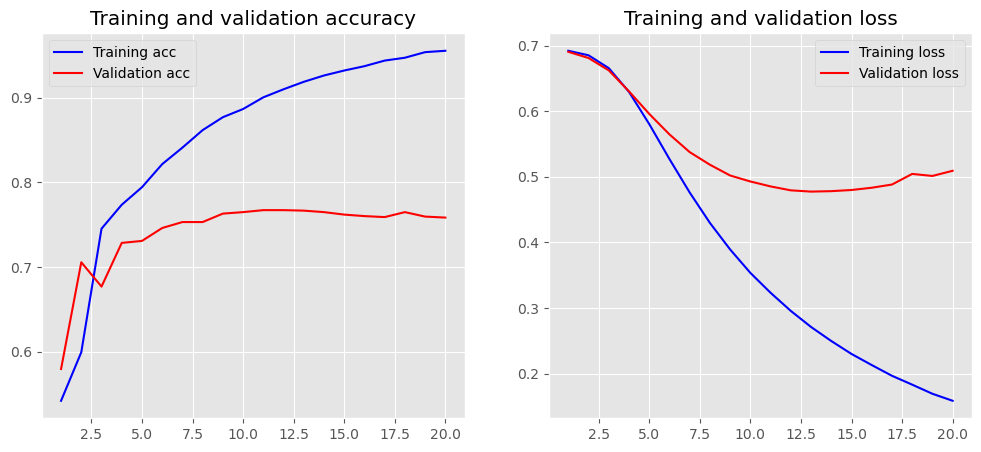

In [38]:
plot_history(history_1)

<Figure size 600x500 with 0 Axes>

Text(0.5, 1.0, 'Training accuracy on e=1')

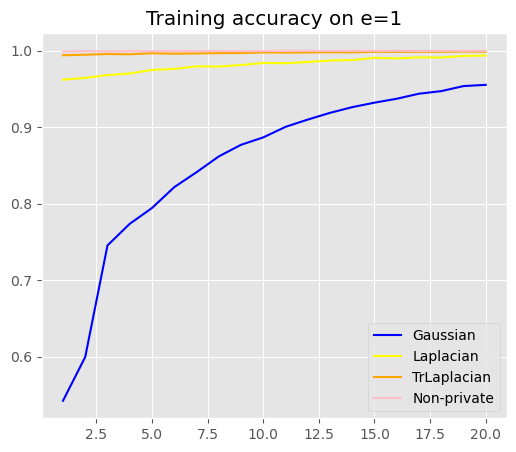

In [39]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
acc_4 = history_4.history['accuracy']
val_acc_4 = history_4.history['val_accuracy']
# loss_1 = history_1.history['loss']
# val_loss_1 = history_1.history['val_loss']
x = range(1, len(acc_1) + 1)

plt.figure(figsize=(6, 5))
# plt.subplot(1, 2, 1)
plt.plot(x, acc_1, 'blue', label='Gaussian')
#plt.plot(x, val_acc_1, 'r', label='TL_Validation acc')
plt.plot(x, acc_2, 'yellow', label='Laplacian')
#plt.plot(x, val_acc_2, 'green', label='L_Validation acc')
plt.plot(x, acc_3, 'orange', label='TrLaplacian')
#plt.plot(x, val_acc_3, 'orange', label='None_Validation acc')
plt.plot(x, acc_4, 'pink', label='Non-private')
#plt.plot(x, val_acc_4, 'cyan', label='G_Validation acc')
plt.title('Training accuracy on e=1')
plt.legend()
plt.savefig("Glove_e_1.png", dpi=500, format="png")

In [ ]:
import pickle
#file = open('./history_3_TL.pkl', 'wb')
#pickle.dump(history_1.history, file)
#file.close()

In [ ]:
f = open('./history_3_L.pkl', 'rb')
his = pickle.load(f)